# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

## Lab Class #10 - Rendering textured pointclouds and meshes

---
#**Personal Info:**
*   **Student:**
    *   Sherlon Almeida da Silva
*   **Affiliation:**
    *   PhD Student
    *   University of São Paulo (USP)
    *   Institute of Mathematics and Computer Science (ICMC)
    *   Laboratory of Visualization, Imaging and Computer Graphics (VICG)
*   **Research & Programming:**
    *   [Lattes](http://lattes.cnpq.br/0000096258045504) | [ORCID](https://orcid.org/0000-0001-6124-9350) | [Google Scholar](https://scholar.google.com.br/citations?user=boFxo4gAAAAJ&hl=pt-BR) | [Linkedin](https://www.linkedin.com/in/SherlonAlmeida/) | [Github](https://github.com/SherlonAlmeida) | [Personal Page](http://vicg.icmc.usp.br/vicg/person/72/sherlon-almeida-da-silva)
---

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=2034e6999485684533e4ebaf473bf6f84a7d1605134814d436bccf7845aa7e57
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=f70f0c86d78dd20bd7e51067268639860b110d715dee8177cd9c0ad1a77ca4bc
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/dow

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

⚠️ ⚠️ ⚠️  If using **Google Colab**, fetch the utils file for plotting image grids:

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2023-06-20 00:28:17--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-06-20 00:28:17 (33.5 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



In [4]:
# uncomment and run this line if running locally
# from utils import image_grid

# Part 1 - Loading a textured mesh and visualizing its texture map

0.1 Download a textured mesh set of files. The .obj describes the mesh structure; The .mtl describes its material and the image (.png) is a texture map.

In [5]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2023-06-20 00:28:17--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.80, 99.84.160.61, 99.84.160.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.04s   

2023-06-20 00:28:17 (8.28 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2023-06-20 00:28:17--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.160.80, 99.84.160.61, 99.84.160.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.160.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[=======

In [6]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

1.1 Load the mesh data using the function `load_objs_as_meshes`. It takes a list of paths to one or multiple .obj file and returns a Meshes object. Don't forget to pass the `device` as argument, so you can benefit of the GPU acceleration.

In [7]:
##############################################################################
# Code for 1.1-1.2.
##############################################################################

In [8]:
src_mesh = load_objs_as_meshes(files=["./data/cow_mesh/cow.obj"], load_textures=True, device=device)

In [9]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

def show_plotly_side_by_side(mesh1, title1):
    # Render the plotly figure
    fig = plot_scene(
        plots= {
          title1: {
              "shapenet_mesh": mesh1
          }
        },
        ncols = 1
    )
    fig.show()

In [10]:
#Observando a malha
show_plotly_side_by_side(src_mesh, "Source Mesh")

1.2 Visualize the texture map loaded with the mesh. You can use the function `texturesuv_image_matplotlib` passing the attribute `textures` of the Meshes instance. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

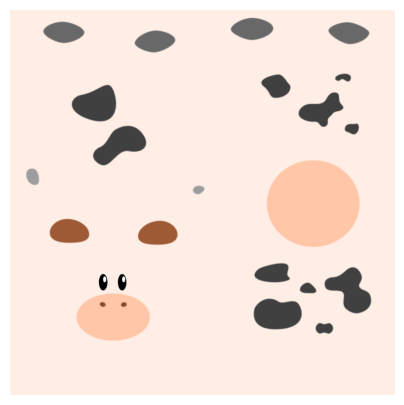

In [11]:
#Mostrando a textura
plt.figure(figsize=(5,5))
texture_image = src_mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

PyTorch3D has a built-in way to view the texture map with matplotlib along with the points on the map corresponding to vertices. There is also a method, texturesuv_image_PIL, to get a similar image which can be saved to a file.

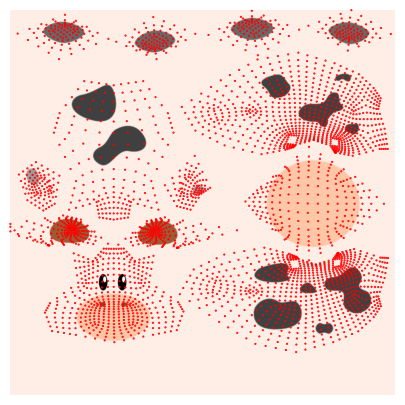

In [12]:
#Apresentando uma projeção dos pontos 3D na imagem da textura
plt.figure(figsize=(5,5))
texturesuv_image_matplotlib(src_mesh.textures, subsample=None)
plt.axis("off");

# Part 2 - Rendering a Mesh

## 2. Create a renderer

A renderer in PyTorch3D is composed of a **rasterizer** and a **shader** which each have a number of subcomponents such as a **camera** (orthographic/perspective). Here we initialize some of these components and use default values for the rest. We will first create a **renderer** which uses a **perspective camera**, a **point light** and applies **phong shading**.

In [13]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.
R, T = look_at_view_transform(2.7, 0, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
# the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the
# -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

## 3. Render the mesh

**You are going to learn more about illumination models in a few weeks. For now, just try to run these experiments to get used to the APIs available in PyTorch3D and write your comments based on your observations.**


2.0 Run the following cell to use the `renderer` function to render the previously loaded mesh. It takes a `Meshes` object and returns a tensor that you can interpret as an image.

In [41]:
def plot_mesh(images, imgSize=(10,10)):
  plt.figure(figsize=imgSize)
  plt.imshow(images[0, ..., :3].cpu().numpy()) #[indice do elemento no batch, ..., RGB]
  plt.grid("off");
  plt.axis("off");

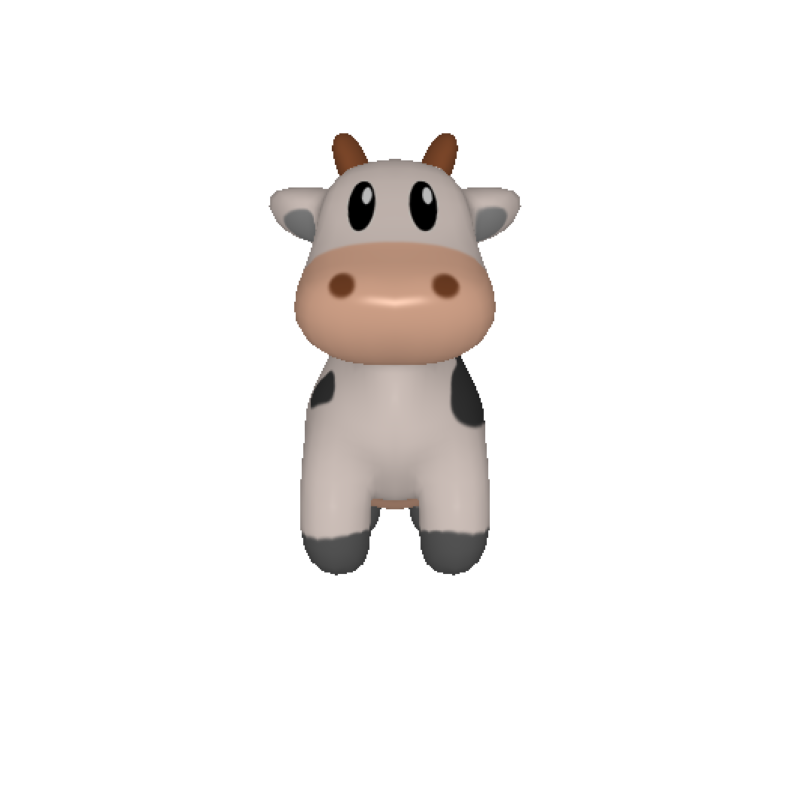

In [15]:
images = renderer(src_mesh)
plot_mesh(images)

In [16]:
from pytorch3d.renderer import (
    SoftGouraudShader,
    SoftSilhouetteShader,
    HardFlatShader
)

2.1 Move the light by changing its location coordinates and render the scene again. You don't need to recreate the renderer to specify a new light setting. When you call your renderer, you can pass a **lights parameter**: `renderer(mesh, lights=newlights)`

In [17]:
##############################################################################
# Code for 2.1-2.3.
##############################################################################

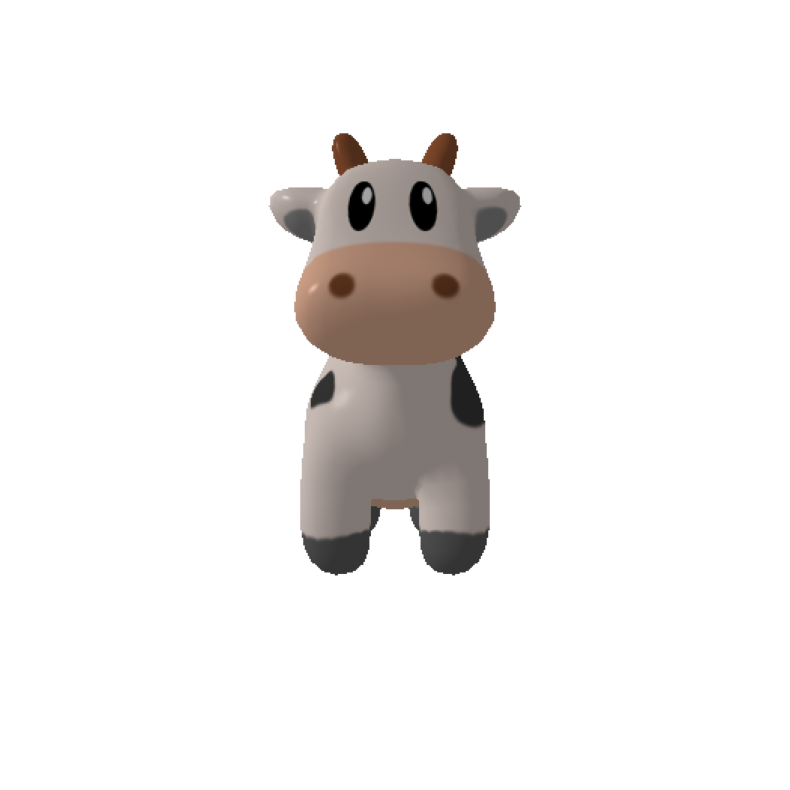

In [18]:
# Definindo novas coordenadas para a luz
newlights = PointLights(device=device, location=[[10.0, 6.0, -3.0]])

images = renderer(src_mesh, lights=newlights)
plot_mesh(images)

2.2 Experiment to define a new renderer using the `HardFlatShader` and render the mesh.

In [19]:
#Usando o HardFlatShader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=HardFlatShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

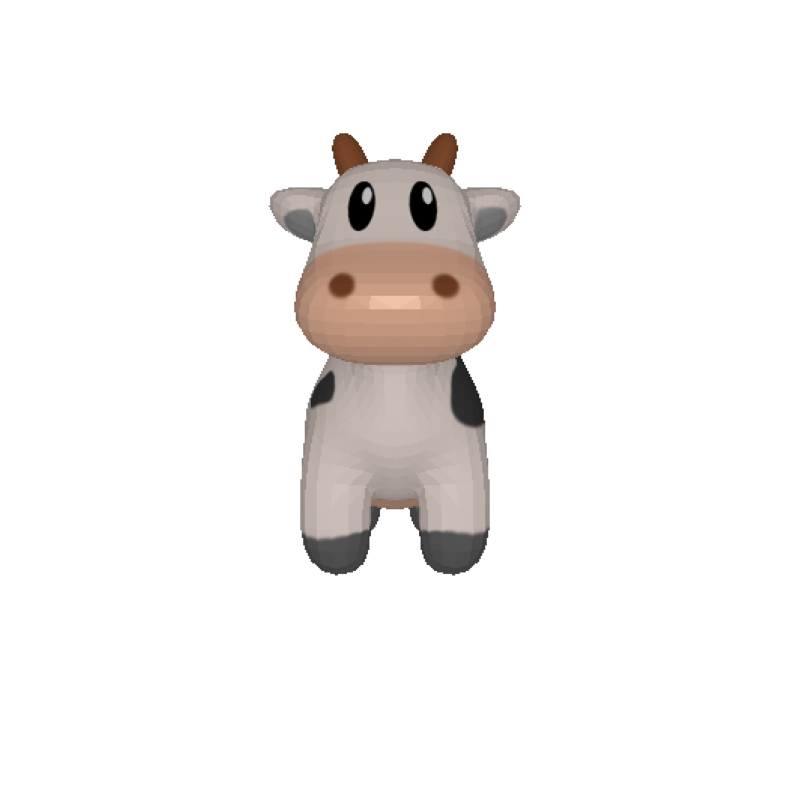

In [20]:
images = renderer(src_mesh)
plot_mesh(images)

2.3 - We can also change the material of a batch of meshes. Define a new `Material` object and experiment changing the **material reflectance** properties of the mesh by specifying new values for the attributes `specular_color` and `shininess`. Again, you can pass a materials parameter as you call your renderer: `renderer(mesh, material=newmaterial)`

In [21]:
#Usando o SoftPhongShader
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=cameras,
        lights=lights
    )
)

In [22]:
#Modificando material
newmaterial = Materials(
    device=device,
    specular_color=[[1.0, 0.0, 0.0]], #RGB
    shininess=4.0
)

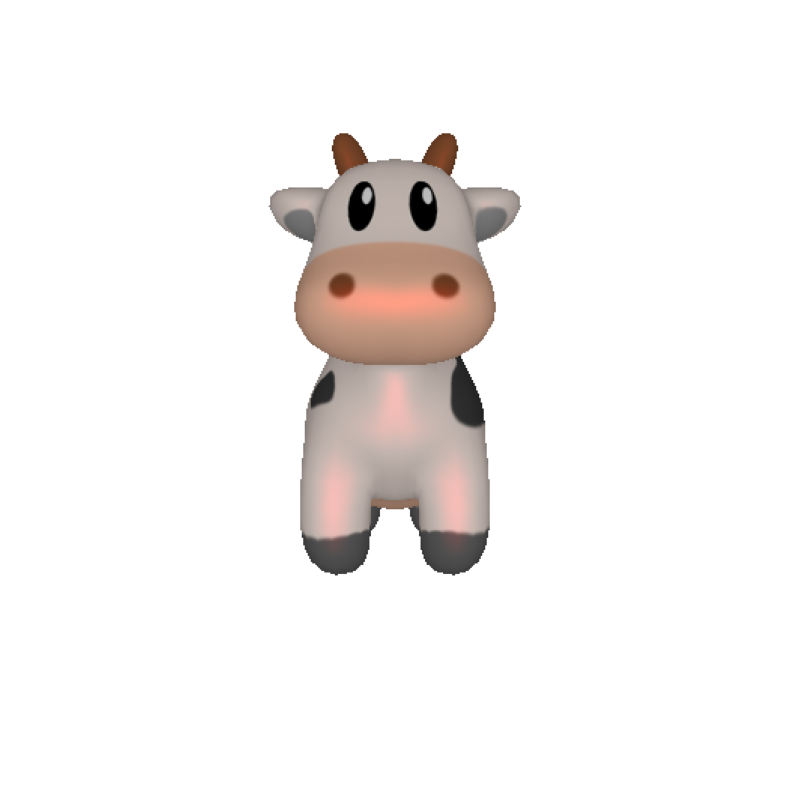

In [23]:
images = renderer(src_mesh, materials=newmaterial)
plot_mesh(images)

### Extra
E.1 Compute the estimated normals for each vertex of the mesh and render a normal map using the `SoftGouraudShader`.

In [24]:
##############################################################################
# Code for E.1
##############################################################################
#Para calcular as normais dos vértices poderia ser utilizada uma média entre as normais das faces adjacentes a cada vértice.

In [25]:
from pytorch3d.ops import estimate_pointcloud_normals

## Parte 3 - Moving the scene

In [26]:
from pytorch3d.transforms import Transform3d, Rotate, Translate

3.1 Check the documentation for the function `look_at_view_transform`. It gives us an intuitive way to define a virtual camera, returning a rotation matrix and translation vector to be applied on the scene. Define a new camera and render the scene from another viewpoint by passing the parameter `cameras` to your renderer: `renderer(mesh, cameras=newcamera)` .

In [27]:
##############################################################################
# Code for 3.1-3.2.
##############################################################################

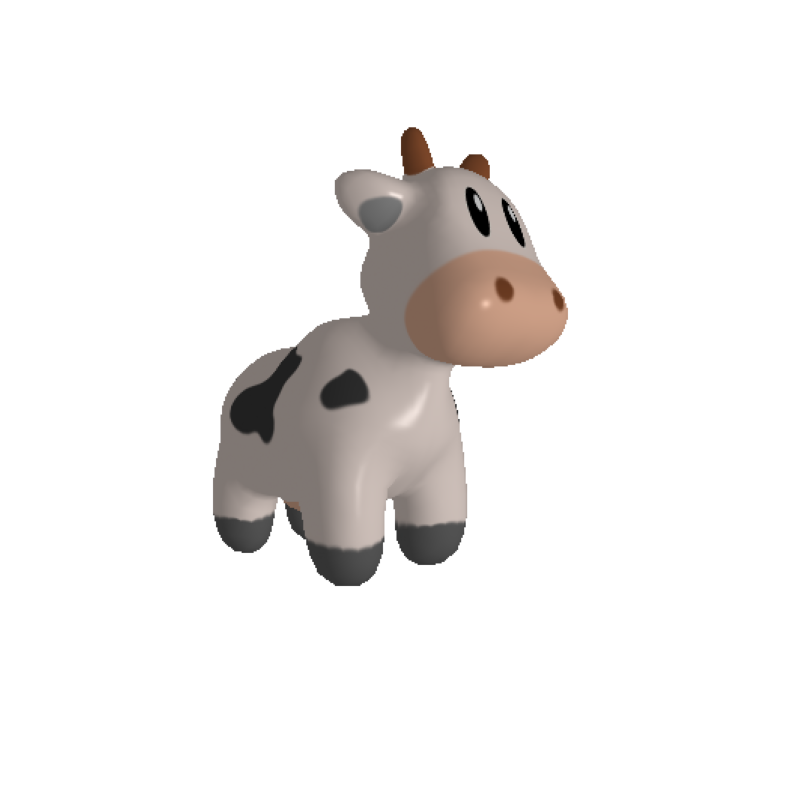

In [28]:
R, T = look_at_view_transform(2.7, 0, 135)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

images = renderer(src_mesh, cameras=cameras)
plot_mesh(images)

3.2 In addition to moving the camera, we can move the object too, by applying a transformation to its vertices. Rotate the mesh by 90 degrees around the vertical axis (Y) and render the scene.

In [29]:
from pytorch3d.transforms import RotateAxisAngle

In [30]:
rotation = RotateAxisAngle(45, axis="X", device=device)
rotated_points = rotation.transform_points(src_mesh.verts_packed())

In [31]:
new_mesh = Meshes(verts=[rotated_points], faces=src_mesh.faces_list(), textures=src_mesh.textures)

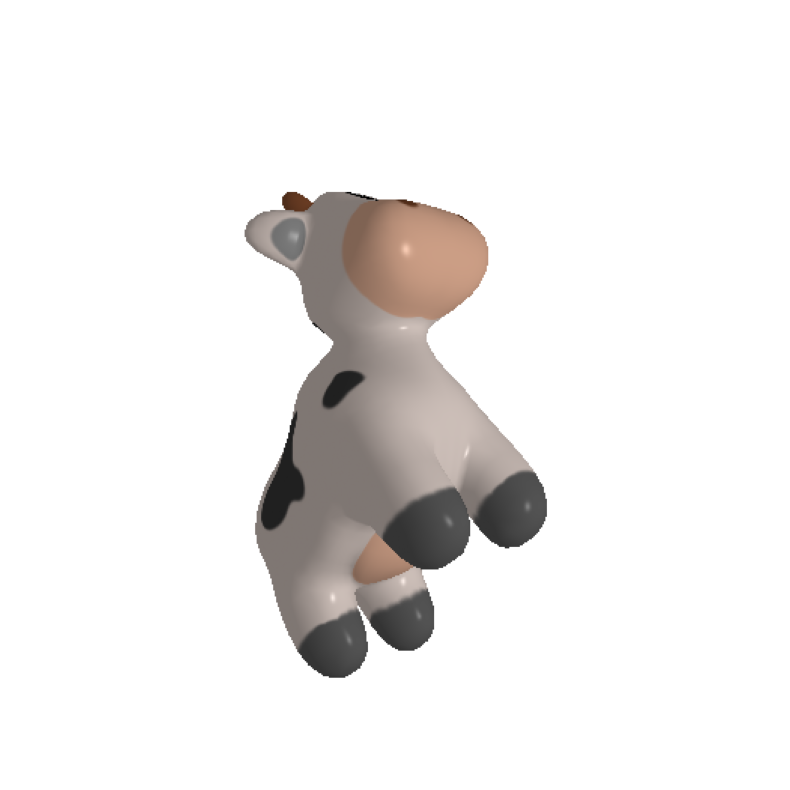

In [32]:
images = renderer(new_mesh, cameras=cameras)
plot_mesh(images)

## Part 4. Batched Rendering

One of the core design choices of the PyTorch3D API is to support **batched inputs for all components**.
The renderer and associated components can take batched inputs and **render a batch of output images in one forward pass**. We will now use this feature to render the mesh from many different viewpoints.


3.0 Run the following cells and observe how the operations are executed in batches.

In [33]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures.
# Meshes has a useful `extend` method which allows us do this very easily.
# This also extends the textures.
meshes = src_mesh.extend(batch_size)

# Get a batch of viewing angles.
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can
# view the camera from the same distance and specify dist=2.7 as a float,
# and then specify elevation and azimuth angles for each viewpoint as tensors.
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the cow which is facing the -z direction.
lights.location = torch.tensor([[0.0, 0.0, -3.0]], device=device)

In [34]:
# We can pass arbitrary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras, lights=lights)

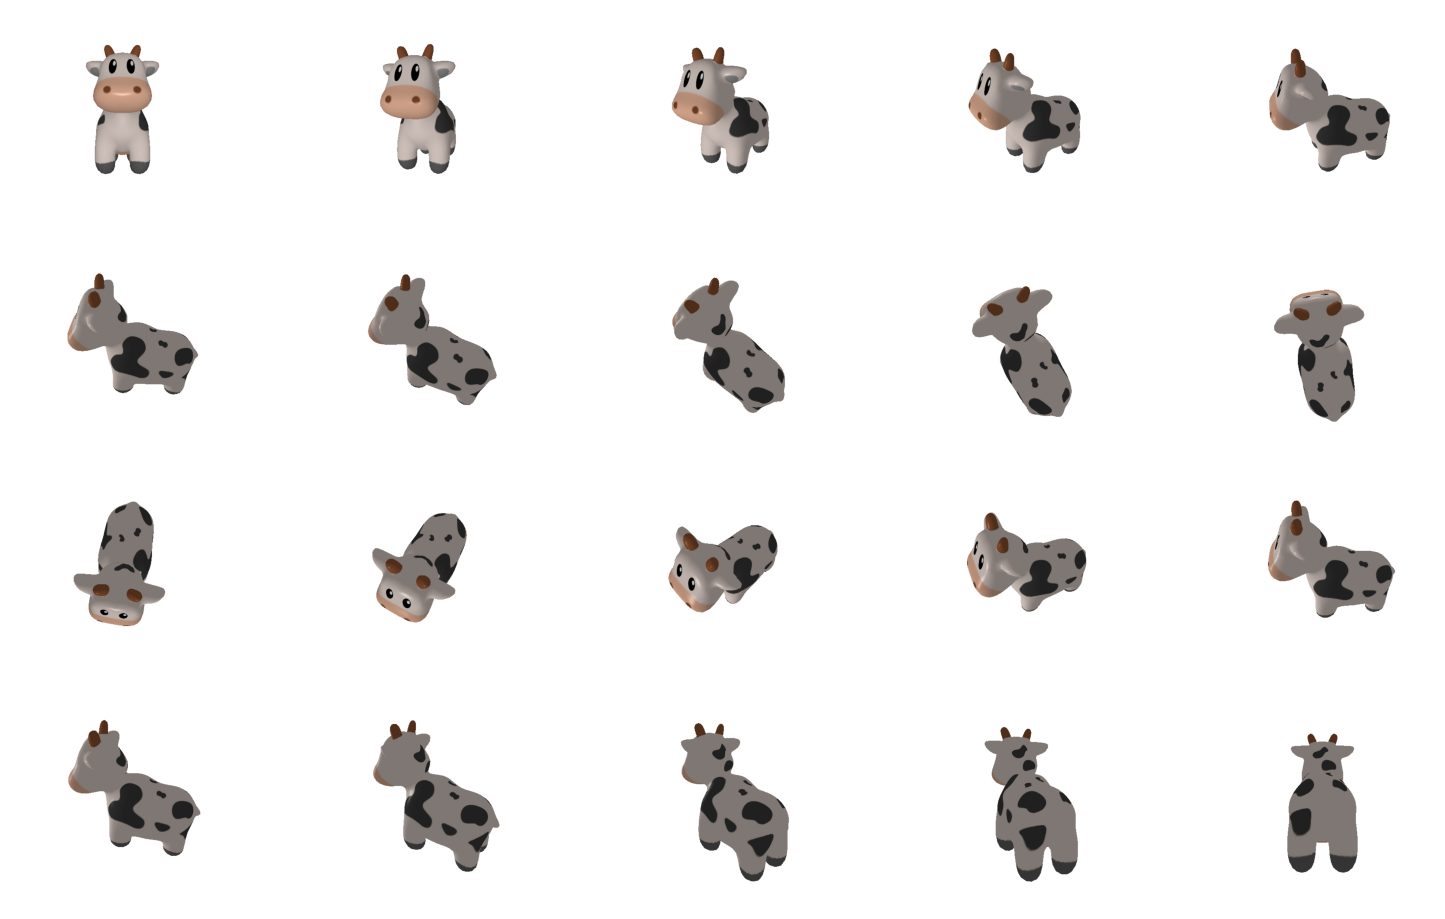

In [35]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

4.2 Create a batch of 2 meshes and use the function `image_grid` to show two different images so that the leftmost should be facing the right direction, while the rightmost should be facing the left direction.

In [36]:
##############################################################################
# Code for 4.1-4.2.
##############################################################################

In [57]:
"""Função para rotacionar uma malha de entrada"""
def rotate_mesh(mesh, angle, axis="X"):
  rotation = RotateAxisAngle(angle, axis=axis, device=device)
  rotated_points = rotation.transform_points(mesh.verts_packed())
  new_mesh = Meshes(verts=[rotated_points], faces=mesh.faces_list(), textures=mesh.textures)
  return new_mesh

"""Função para transladar uma malha de entrada"""
def translation_mesh(mesh, axis=[0,0,0]):
  obj = RotateAxisAngle(0, device=device)
  translated_points = obj.transform_points(mesh.verts_packed() + torch.tensor(axis, device=device))
  new_mesh = Meshes(verts=[translated_points], faces=mesh.faces_list(), textures=mesh.textures)
  return new_mesh

In [60]:
#Rotation
first_cow  = rotate_mesh(src_mesh, 90, "Y")
second_cow = rotate_mesh(src_mesh, 270, "Y")

In [61]:
#Translation
first_cow  = translation_mesh(first_cow,  axis=[1,0,0])
second_cow = translation_mesh(second_cow, axis=[-1,0,0])

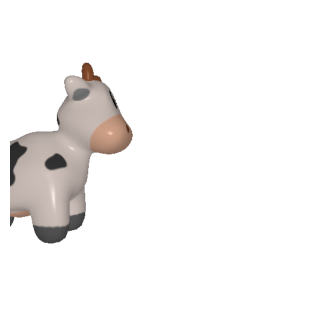

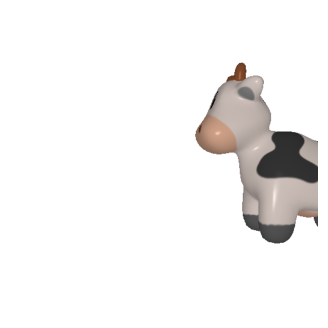

In [62]:
#Plot individualmente
images = renderer(first_cow)
plot_mesh(images, imgSize=(4,4))

images = renderer(second_cow)
plot_mesh(images, imgSize=(4,4))

In [63]:
from pytorch3d.structures.meshes import join_meshes_as_scene
scene = join_meshes_as_scene([first_cow, second_cow])

In [64]:
R, T = look_at_view_transform(dist=5.0, elev=0.0, azim=180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

4.1 Use any configuration of camera and object transformations to render **a single image** of a scene with two equal objects facing each other with some space between them.

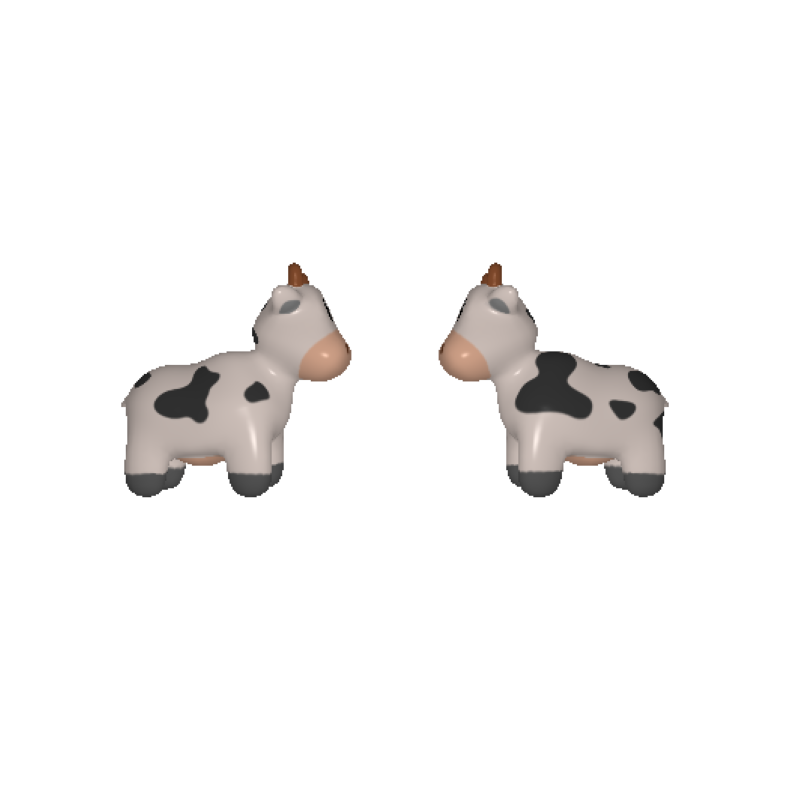

In [65]:
images = renderer(scene, cameras=cameras)
plot_mesh(images)

## Part 5. Rendering Point Clouds

In [66]:
import numpy as np

from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    FoVOrthographicCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

### Load a point cloud and corresponding colors

Load and create a **Point Cloud** object.

**Pointclouds** is a unique datastructure provided in PyTorch3D for working with batches of point clouds of different sizes.

If running this notebook using **Google Colab**, run the following cell to fetch the pointcloud data and save it at the path `data/PittsburghBridge`:
If running locally, the data is already available at the correct path.

In [71]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [72]:
!mkdir -p data/PittsburghBridge
!wget -P data/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

--2023-06-20 00:58:07--  https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.125.2, 52.84.125.65, 52.84.125.87, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.125.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5701352 (5.4M) [application/zip]
Saving to: ‘data/PittsburghBridge/pointcloud.npz’

pointcloud.npz      100%[===================>]   5.44M  --.-KB/s    in 0.09s   

2023-06-20 00:58:07 (63.9 MB/s) - ‘data/PittsburghBridge/pointcloud.npz’ saved [5701352/5701352]



In [73]:
# Set paths
DATA_DIR = "./data"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")
# Load point cloud and colors
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)
rgb = torch.Tensor(pointcloud['rgb']).to(device)
point_cloud = Pointclouds(points=[verts], features=[rgb])

In [74]:
# Initialize a camera.
R, T = look_at_view_transform(20, 10, 0)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters.
raster_settings = PointsRasterizationSettings(
    image_size=512,
    radius = 0.003,
    points_per_pixel = 10
)

# Create a points renderer by compositing points using an alpha compositor (nearer points
# are weighted more heavily).
rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
pcrenderer = PointsRenderer(
    rasterizer=rasterizer,
    compositor=AlphaCompositor()
)

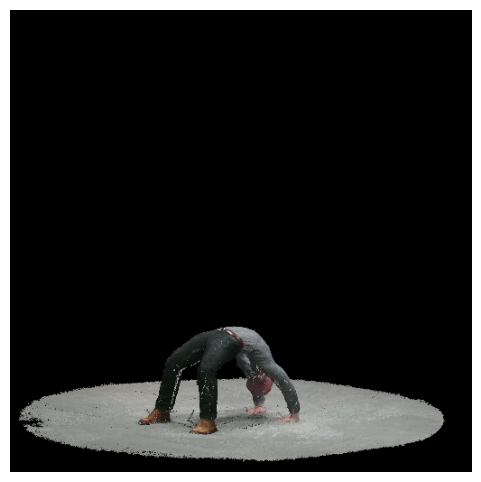

In [76]:
images = pcrenderer(point_cloud)
plt.figure(figsize=(6, 6))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

We will now modify the **renderer** to use **weighted compositing** with a set background color.

In [77]:
pcrenderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    # Pass in background_color to the norm weighted compositor, setting the background color
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case red
    compositor=NormWeightedCompositor(background_color=(1,0,0))
)

5.1 Render and display a new image of the PointCloud.

In [ ]:
##############################################################################
# Code for 5.1-5.2.
##############################################################################

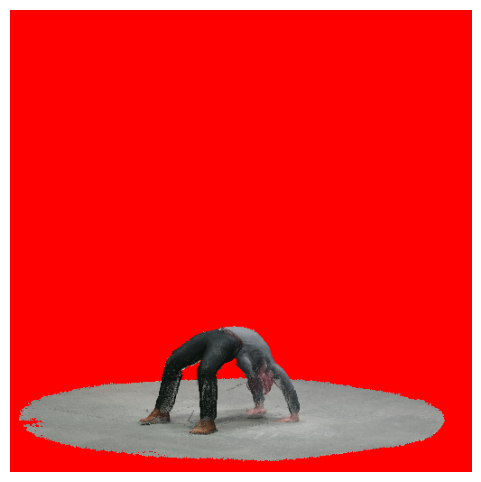

In [78]:
images = pcrenderer(point_cloud)
plt.figure(figsize=(6, 6))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

5.2 Experiment changing the background color

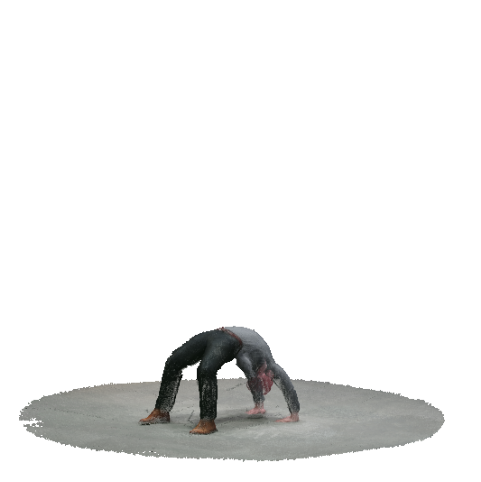

In [81]:
pcrenderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    # Pass in background_color to the norm weighted compositor, setting the background color
    # to the 3 item tuple, representing rgb on a scale of 0 -> 1, in this case red
    compositor=NormWeightedCompositor(background_color=(1,1,1))
)

images = pcrenderer(point_cloud)
plt.figure(figsize=(6, 6))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

## Using the pulsar backend

Switching to the pulsar backend is easy! The pulsar backend has a compositor built-in, so the `compositor` argument is not required when creating it (a warning will be displayed if you provide it nevertheless). It pre-allocates memory on the rendering device, that's why it needs the `n_channels` at construction time.

All parameters for the renderer forward function are batch-wise except the background color (in this example, `gamma`) and you have to provide as many values as you have examples in your batch. The background color is optional and by default set to all zeros. You can find a detailed explanation of how gamma influences the rendering function here in the paper [Fast Differentiable Raycasting for Neural Rendering using
Sphere-based Representations](https://arxiv.org/pdf/2004.07484.pdf).

You can also use the `native` backend for the pulsar backend which already provides access to point opacity. The native backend can be imported from `pytorch3d.renderer.points.pulsar`; you can find examples for this in the folder `docs/examples`.

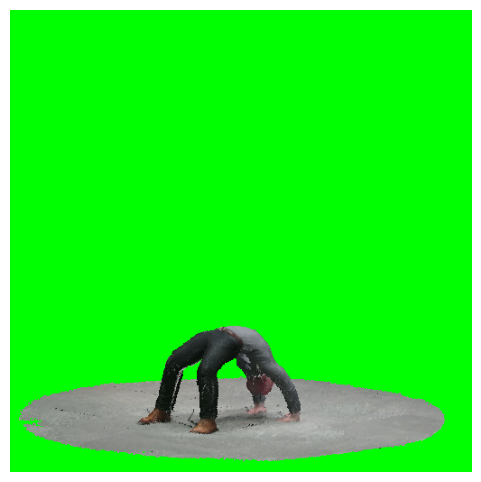

In [83]:
pcrenderer = PulsarPointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    n_channels=4
).to(device)

images = pcrenderer(point_cloud, gamma=(1e-4,),
                  bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))
plt.figure(figsize=(6, 6))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off");

5.3 Create a batch of pointclouds and render the scene with different viewpoints and background colors.

In [ ]:
##############################################################################
# Code for 5.1-5.2.
##############################################################################

In [124]:
batch_size = 12
pc = point_cloud.extend(batch_size)
elev = torch.linspace(0, 180, batch_size)
azim = torch.linspace(-180, 180, batch_size)
R, T = look_at_view_transform(dist=5.0, elev=elev, azim=azim)
cameras = FoVOrthographicCameras(device=device, R=R, T=T, znear=0.01)

rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
pcrenderer = PulsarPointsRenderer(
    rasterizer=rasterizer,
    n_channels=4
).to(device)

In [125]:
# We can pass arbitrary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = pcrenderer(pc,
                    gamma=[1e-4]*len(pc),
                    bg_col=torch.tensor([0.0, 1.0, 0.0, 1.0], dtype=torch.float32, device=device))

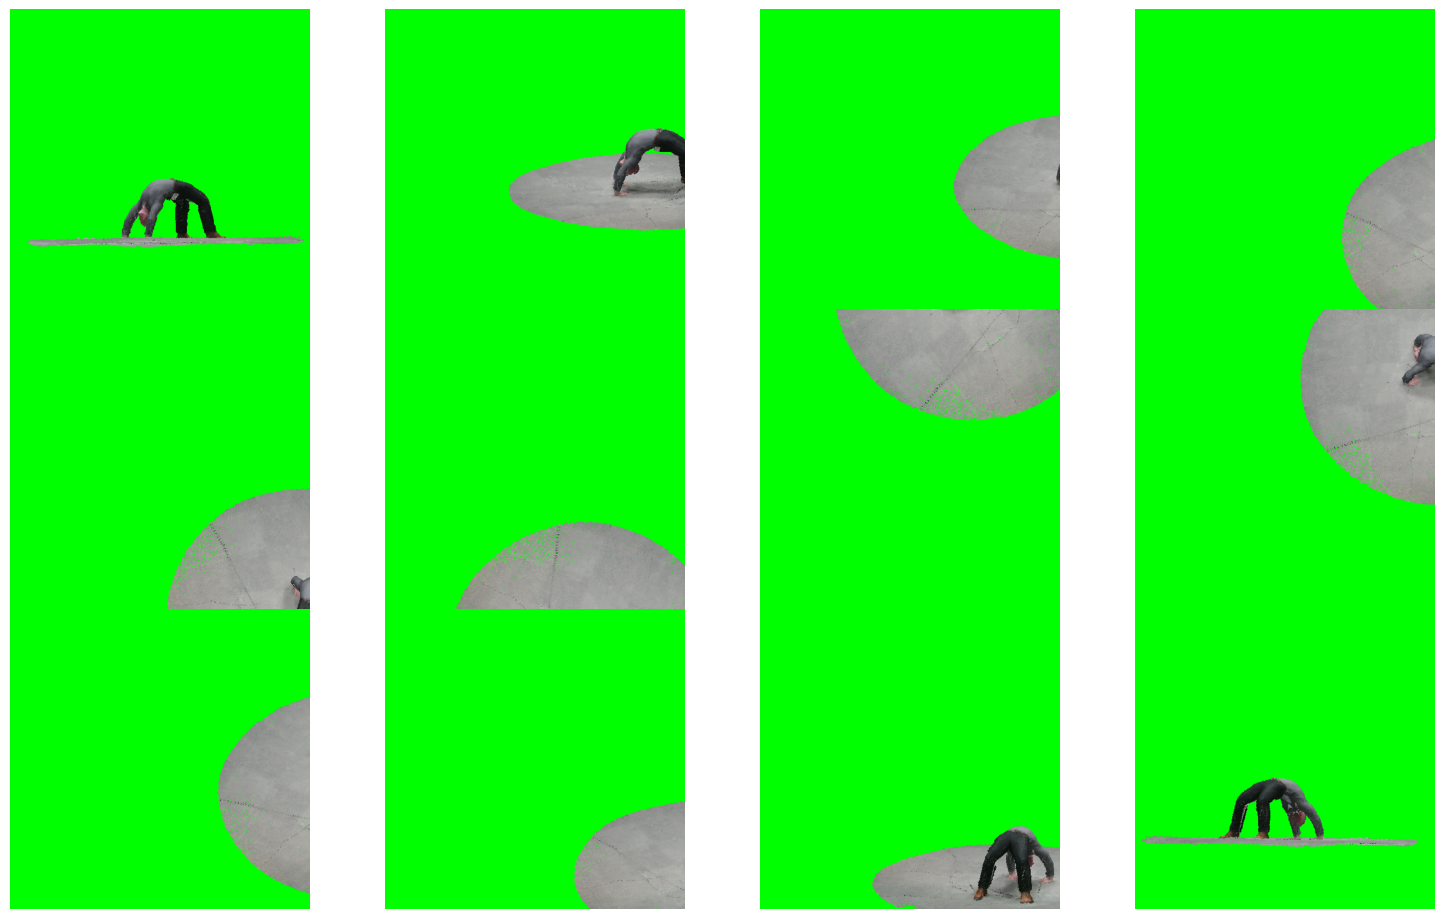

In [127]:
image_grid(images.cpu().numpy(), rows=3, cols=4, rgb=True)